# Adding the ARCANE example target

**MATCH** (**M**odel-**A**ware **T**VM-based **C**ompiler for **H**eterogeneous hardware) is a DNN compiler that exploits [Apache TVM](https://tvm.apache.org/)'s BYOC framework, targeting the optimized deployment of DNN applications onto heterogeneous edge System-on-Chip (SoC) platforms.

MATCH is designed to make the process of supporting new targets as simple as possible, thanks to a compilation process guided by _high-level model-based hardware abstractions_. Read below for instructions on this extension process.

### How to support a new target in MATCH
- create a class extending MatchTarget; this class serves as the core for the compilation, each MatchTargets embeds offloading units and the common memory hierarchy of the target, some of the needed methods to override are the following:
- - host\_memories: this methods define the common hierarchy of the target
- - network\_transformations: this method should return the common list of transformations to apply to the network(for instance layout related)
- create for each executional module a class extending ExecModule; this class handles the offloading of a node to a specific executional module, to achieve this some methods have to be overrided:
- - partitioning\_patterns: this method defines the list of patterns that are supported by the module, for instance an accelerator may support a fused Conv2D + BatchNorm + Relu and a fused Dense +  BatchNorm + Relu nodes.
- - update_constants: method to adapt the constants to the layout expected by the module(i.e. and accelerator may expect the weights in the layout)
- - apis methods(comp\_apis\_def, mem\_apis\_def, sync\_apis\_def, platform\_apis\_def): these methods receive an object of the specific APIs type and can update the name of the API used for the wanted functionality(sw-controlled memory transfer, memory allocation, backend computation etc.)
- - network\_transformations: this method should return the list of transformations to apply specific to the module(for instance padding)
- - when using ZigZag as the optimization engine additional methods could be implemented:
- - - zigzag\_cost\_model: this method should return the class of the analytical cost model that ZigZag should use; this class should extend the ZigZagMatchCostModel one, and override the def\_transfer\_cost and def\_innermost\_loops\_cost methods to define the latency and energy cost of a node for the specific pattern and executional module. During this notebook this part will not be detailed since our scope is a simple extension to support an acclelerator and we'll rely on the default cost model.
- - - zigzag\_optimal\_spatial\_mapping\_def: this method should define the apriori-known spatial mapping of the executional module for each pattern(for instance an accelerator may parallelize with a factor of 16 over output channels). Noteworthy, the dimensions are expected with their ZigZag naming counterpart. This part will also not be detailed since for our simple test case it is not required.

In [1]:
# setup environment variables of MATCH and TVM
import os
CURR_PATH = "./"
MATCH_PATH = "./../../../"
TVM_HOME = f"{MATCH_PATH}/match-tvm"
os.environ["TVM_HOME"] = TVM_HOME
os.environ["PYTHONPATH"] = f"{TVM_HOME}/python:{MATCH_PATH}/zigzag:{os.environ['PYTHONPATH']}"
# MATCH imports
import match
from match.target.target import MatchTarget
from match.target.memory_inst import MemoryInst
from match.transform.requant import MatchRequantRewriter
from match.target.exec_module import ExecModule, ModuleLib
from match.partition.partitioning_pattern import PartitioningPattern
from match.target.exec_module import ComputationalApis
from match.node.node import MatchNode
from match.utils.utils import get_default_inputs
from match.model.model import MatchModel
from tvm.relay.dataflow_pattern import wildcard, is_op, is_constant
from tvm import relay
import onnx

from utils import ARCANE_PROFILING, CPU_ONLY_PROFILING
import matplotlib as mlib
import matplotlib.pyplot as plt

## ARCANE on MATCH
First let's define the X-Heep SoC MatchTarget that contains the ARCANE NMC module!
```python
class XHeepSoC(MatchTarget):
    def __init__(self):
        super().__init__(
            exec_modules = []
            , name = "xheepsoc",
        )
```
This target should be comprised of a single excutional module, the ARCANE NMC module.
```python
class Arcane(ExecModule):
    def __init__(self):
        super().__init__(
            name = "arcane",
            libs_required = {
                "arcane_helper": ModuleLib(name="arcane_helper", base_path=CURR_PATH+"/arcane_helper"),
            },
        )

class XHeepSoC(MatchTarget):
    def __init__(self):
        super().__init__(
            exec_modules = [ Arcane() ]
            , name = "xheepsoc",
        )
```
Currently as an example we want to offload, and accelerate, to the NMC module the compute-intensive matrix multiplications.
To achieve this we should overrided in the Carus ExecModule the partitioning\_patterns method:
```python
class Arcane(ExecModule):
    ...
    def partitioning_patterns(self):

        def dense_pt():
            """Create pattern for matmul."""
            dense = is_op("nn.dense")(
                wildcard(), is_constant()
            )
            return dense

        return [
            PartitioningPattern(
                name="DENSE_PT",
                pattern=dense_pt,
            ),
        ]
```
Additionally, we can put constraints on the pattern itself, in this case the NMC module expects data to be stored in int32, we can achieve this by adding to the PartitioningPattern.
```python
class Arcane(ExecModule):
    ...
    def partitioning_patterns(self):

        def dense_pt():
            """Create pattern for matmul."""
            dense = is_op("nn.dense")(
                wildcard(), is_constant()
            )
            return dense

        def only_int32_dense(node):
            # node is already just the dense TVM Call Node
            dense = node
            if dense.checked_type.dtype != "int32":
                return False
            return True

        return [
            PartitioningPattern(
                name="DENSE_PT",
                pattern=dense_pt,
                additional_checks=only_int32_dense
            ),
        ]
```
The NMC module expects also the weights of the matrix multiplication to be stored in the CN layout(input channels, output channels) instead of the default NC one(output channels, input channels).
This can be achieved by overriding the update\_constants method, checking the constants associated with the dense operation.
```python
class Arcane(ExecModule):
    ...
    def update_constants(self, match_node: MatchNode=None, pattern_name: str="DENSE_PT"):
        for w_tensor in match_node.const_tensors.values():
            if "dense" in w_tensor.name:
                if w_tensor.layout!="CN":
                    w_tensor.data = w_tensor.data.transpose(1,0)
                    w_tensor.dims = [w_tensor.dims[1], w_tensor.dims[0]]
                w_tensor.layout = "CN"
```
The next steps instead require plugging the library that will be exploited by MATCH, this is achieved in 3 points:
- define the APIs(in this case only the computational one)
- add to the constructor also the library required to load(we'll call it carus_helper)
- add the include paths needed
```python
class Arcane(ExecModule):
    def __init__(self):
        super().__init__(
            name = "arcane",
            libs_required = {
                "arcane_helper": ModuleLib(name="arcane_helper", base_path=CURR_PATH+"/arcane_helper"),
            },
        )
    ...
    def comp_apis_def(self, computational_apis: ComputationalApis=None, pattern_name = "DENSE_PT"):
        computational_apis.compute_tile = "arcane_compute_wrapper"
        return computational_apis
    def include_list(self):
        return ["arcane_helper/arcane_helper"]
```
Finally, coming back to the ARCANE MatchTarget we want to add a transformation(available directly from MATCH) to transform more compute-demanding(and not always available) division operations with right shift ones.
```python
class XHeepSoC(MatchTarget):
    ...
    def network_transformations(self, opts):
        return [
            ("requant", MatchRequantRewriter()),
        ]
```
Another step is the definition of the memory hierarchy of the ARCANE target.
```python
ARCANE_L2_MEMORY_SIZE = 8*32*1024
class XHeepSoC(MatchTarget):
    ...
    def host_memories(self):
        return [
            MemoryInst(name="ARCANE_L2_MEM", k_bytes=ARCANE_L2_MEMORY_SIZE),
        ]
```
Finally, before moving in to the plugin library(carus_helper) we should also define for the MatchTarget required include paths and the paths for possible redefinitions of additional components(Makefile, tvm_runtime.c, tvm_runtime.h, where the last 2 should just implement if defined differently memory allocations etc.), and finally also the name of the target-specific APIs.
```python
ARCANE_L2_MEMORY_SIZE = 8*32*1024
class XHeepSoC(MatchTarget):
    def __init__(self):
        ...
        self.makefile_path = CURR_PATH+"/arcane_lib/Makefile"
        self.tvm_runtime_include_path = CURR_PATH+"/arcane_lib/tvm_runtime.h"
        self.tvm_runtime_src_path = CURR_PATH+"/arcane_lib/tvm_runtime.c"
        self.init_funcs = ["arcane_helper_init_l1_mem"]
        self.include_list = ["arcane_helper/arcane_helper"]
```

In [2]:
ARCANE_L2_MEMORY_SIZE = 8*32*1024

class Arcane(ExecModule):
    def __init__(self):
        super().__init__(
            name = "arcane",
            libs_required = {
                "arcane_helper": ModuleLib(name="arcane_helper", base_path=CURR_PATH+"/arcane_helper"),
            },
        )
    
    def partitioning_patterns(self):

        def dense_pt():
            """Create pattern for matmul."""
            dense = is_op("nn.dense")(
                wildcard(), is_constant()
            )
            return dense

        def only_int32_dense(node):
            # node is already just the dense TVM Call Node
            dense = node
            if dense.checked_type.dtype != "int32":
                return False
            return True

        return [
            PartitioningPattern(
                name="DENSE_PT",
                pattern=dense_pt,
                additional_checks=only_int32_dense
            ),
        ]

    def comp_apis_def(self, computational_apis: ComputationalApis=None, pattern_name = "dense"):
        computational_apis.compute_tile = "arcane_compute_wrapper"
        return computational_apis
    
    def update_constants(self, match_node: MatchNode=None, pattern_name: str="dense"):
        for w_tensor in match_node.const_tensors.values():
            if "dense" in w_tensor.name:
                if w_tensor.layout!="CN":
                    w_tensor.data = w_tensor.data.transpose(1,0)
                    w_tensor.dims = [w_tensor.dims[1], w_tensor.dims[0]]
                w_tensor.layout = "CN"
                
    def include_list(self):
        return ["arcane_helper/arcane_helper"]

class XHeepSoC(MatchTarget):
    def __init__(self):
        super().__init__(
            exec_modules = [
                Arcane()
            ]
            , name = "xheepsoc",
        )
        self.makefile_path = CURR_PATH+"/arcane_lib/Makefile"
        self.tvm_runtime_include_path = CURR_PATH+"/arcane_lib/tvm_runtime.h"
        self.tvm_runtime_src_path = CURR_PATH+"/arcane_lib/tvm_runtime.c"
        self.init_funcs = ["arcane_helper_init_l1_mem"]
        self.include_list = ["arcane_helper/arcane_helper"]

    def network_transformations(self, opts):
        return [
            ("requant", MatchRequantRewriter()),
        ]

    def host_memories(self):
        return [
            MemoryInst(name="ARCANE_L2_MEM", k_bytes=ARCANE_L2_MEMORY_SIZE),
        ]

## PLUGIN LIBRARY ARCANE\_HELPER
As we defined earlier this library should contain 2 methods, the one we called arcane\_compute\_wrapper and arcane\_helper\_init\_l1\_mem:
```c
void arcane_helper_init_l1_mem(){
    l1_hal_init(0, l1_loader, sizeof(l1_loader), 1);
}

void arcane_compute_wrapper(MatchCtx* ctx){
    MatchTensor* tensors = ctx->tensors->tensors;
    int num_tensors = ctx->tensors->num_tensors;
    int out_chs = tensors[num_tensors-1].tiles[1].size;
    int inp_chs = tensors[0].tiles[1].size;
    // reserve matrix in the ARCANE NMC module for the activations
    xmr(m0, tensors[0].pt, 1, inp_chs, 1, 1);
    // reserve matrix in the ARCANE NMC module for weights stored in CN format
    xmr(m1, tensors[1].pt, inp_chs, out_chs, 1, 1);
    // reserve matrix in the ARCANE NMC module for the outputs
    xmr(m2, tensors[num_tensors-1].pt, 1, out_chs, 1, 1);
    // dense op
    carus_mmul_tiling(m2, m0, m1, mNONE, 0, 0);
}
```
arcane\_compute\_wrapper is a function that accepts the MatchCtx structure, which contains all the relevant information about the current node(its tensors, its operations, the pattern name etc.), and should compute its operations.
This is done by reserving in the NMC 3 matrixes(activations, weights and output) and relying on the NMC backend library(more specifically the carus\_mmul\_tiling function).
arcane\_helper\_init\_l1\_mem instead is called by the main.c and initializes the target, in this case by activating the NMC memory instance.

## MNIST-Net Compilation
During this notebook we'll use the network in the model directory, which comprise the mnist.onnx file, a pre-trained network later integerized with PLiNIO https://github.com/eml-eda/plinio to int32 to target ARCANE, the expected outputs at each layer, rescaling values, the input file and the respective output label.
In the PLiNIO repository there are examples to reproduce the model directory, where we have our input, the expected label and finally also the model itself.
With an int32 ONNX model that classifies numbers trained on the MNIST dataset we can then compile it and execute it on the ARCANE target!
Let's then compile the mnist.onnx in this repository with MATCH!
We'll first define a MatchModel, which is a definition of the model to compile, so the path of the ONNX model, the name of the model, executor used(graph or AOT) and more.
```python
onnx_file_path = CURR_PATH+"/model/mnist.onnx"
mnist_model = MatchModel(
    filename="mnist.onnx",
    model_name="mnist"
)
```
At the end of the inference we want also to print through the device the classification result of the MNIST-Net, so we can add a handle\_out\_fn parameter.
We'll use one of the MATCH-output-handling functions, in this case handle\_int\_classifier.
Additionally we want also to use the inputs defined in a file, this can be done with the get\_default\_inputs utility.
```python
input_file = CURR_PATH+"/model/input.txt"
onnx_file_path = CURR_PATH+"/model/mnist.onnx"
onnx_model = onnx.load(onnx_file_path)
mod, _ = relay.frontend.from_onnx(onnx_model)
mnist_model = MatchModel(
    filename=onnx_file_path,
    model_name="mnist",
    default_inputs=get_default_inputs(mod=mod, input_files=[input_file]),
    handle_out_fn="handle_int_classifier",
)
```

In [ ]:
input_file = CURR_PATH+"/model/input.txt"
onnx_file_path = CURR_PATH+"/model/mnist.onnx"
onnx_model = onnx.load(onnx_file_path)
mod, _ = relay.frontend.from_onnx(onnx_model)
mnist_model = MatchModel(
    filename=onnx_file_path,
    model_name="mnist",
    default_inputs=get_default_inputs(mod=mod, input_files=[input_file]),
    handle_out_fn="handle_int_classifier",
)

In [4]:
match.match(
    model=mnist_model,
    target=XHeepSoC(),
    output_path=CURR_PATH+"/output",
)

2025-04-28 15:46:32,868 - parse_workload_from_path_or_from_module +42 - INFO - Created workload graph with 1 nodes and 0 edges.
2025-04-28 15:46:32,869 - run +29 - INFO - Processing layer 0...
2025-04-28 15:46:32,869 - run +89 - INFO - Launching spatial mapping 1/1: {'D1': ('K', 1), 'D2': ('OY', 1)}.
2025-04-28 15:46:32,869 - run +74 - INFO - Running temporal mapping search engine...


-------------------
[PATTERN MATCHER] Node matched pattern xheepsoc.arcane.DENSE_PT, checking additional conditions
Looking for temporal mapping with following spatial mapping {'DENSE_PT': {'core_allocation': 1, 'spatial_mapping': {'D1': ('K', 1), 'D2': ('OY', 1)}, 'memory_operand_links': {'I': 'I1', 'W': 'I2', 'O': 'O'}, 'unordered_loops': ['FX', 'FY', 'C']}}


 12%|█▎        | 1/8 [00:00<00:00, 837.19it/s]
2025-04-28 15:46:32,874 - run +44 - INFO - Saved CostModelEvaluation(layer=None, core=1) with energy 0.000e+00 and latency 0.000e+00 to tmp/match-layer_None_complete.json
2025-04-28 15:46:32,875 - run +98 - INFO - Saved CostModelEvaluation(layer=None, core=1) with energy 0.000e+00 and latency 0.000e+00 to tmp/match-layer_None_simple.json
2025-04-28 15:46:32,883 - run +146 - INFO - Saved pickled list of 1 CMEs to tmp/match-saved_list_of_cmes.pickle.
2025-04-28 15:46:32,904 - parse_workload_from_path_or_from_module +42 - INFO - Created workload graph with 1 nodes and 0 edges.
2025-04-28 15:46:32,905 - run +29 - INFO - Processing layer 0...
2025-04-28 15:46:32,905 - run +89 - INFO - Launching spatial mapping 1/1: {'D1': ('K', 1), 'D2': ('OY', 1)}.
2025-04-28 15:46:32,905 - run +74 - INFO - Running temporal mapping search engine...


[PATTERN MATCHER] Node is supported by xheepsoc.arcane.DENSE_PT with expected latency 0 and expected energy 0
-------------------
[PATTERN MATCHER] Node matched pattern xheepsoc.arcane.DENSE_PT, checking additional conditions
Looking for temporal mapping with following spatial mapping {'DENSE_PT': {'core_allocation': 1, 'spatial_mapping': {'D1': ('K', 1), 'D2': ('OY', 1)}, 'memory_operand_links': {'I': 'I1', 'W': 'I2', 'O': 'O'}, 'unordered_loops': ['FX', 'FY', 'C']}}


 14%|█▍        | 1/7 [00:00<00:00, 931.65it/s]
2025-04-28 15:46:32,909 - run +44 - INFO - Saved CostModelEvaluation(layer=None, core=1) with energy 0.000e+00 and latency 0.000e+00 to tmp/match-layer_None_complete.json
2025-04-28 15:46:32,909 - run +98 - INFO - Saved CostModelEvaluation(layer=None, core=1) with energy 0.000e+00 and latency 0.000e+00 to tmp/match-layer_None_simple.json
2025-04-28 15:46:32,910 - run +146 - INFO - Saved pickled list of 1 CMEs to tmp/match-saved_list_of_cmes.pickle.
2025-04-28 15:46:32,932 - parse_workload_from_path_or_from_module +42 - INFO - Created workload graph with 1 nodes and 0 edges.
2025-04-28 15:46:32,933 - run +29 - INFO - Processing layer 0...
2025-04-28 15:46:32,933 - run +89 - INFO - Launching spatial mapping 1/1: {'D1': ('K', 1), 'D2': ('OY', 1)}.
2025-04-28 15:46:32,934 - run +74 - INFO - Running temporal mapping search engine...


[PATTERN MATCHER] Node is supported by xheepsoc.arcane.DENSE_PT with expected latency 0 and expected energy 0
-------------------
[PATTERN MATCHER] Node matched pattern xheepsoc.arcane.DENSE_PT, checking additional conditions
Looking for temporal mapping with following spatial mapping {'DENSE_PT': {'core_allocation': 1, 'spatial_mapping': {'D1': ('K', 1), 'D2': ('OY', 1)}, 'memory_operand_links': {'I': 'I1', 'W': 'I2', 'O': 'O'}, 'unordered_loops': ['FX', 'FY', 'C']}}


 33%|███▎      | 2/6 [00:00<00:00, 1126.44it/s]
2025-04-28 15:46:32,938 - run +44 - INFO - Saved CostModelEvaluation(layer=None, core=1) with energy 0.000e+00 and latency 0.000e+00 to tmp/match-layer_None_complete.json
2025-04-28 15:46:32,938 - run +98 - INFO - Saved CostModelEvaluation(layer=None, core=1) with energy 0.000e+00 and latency 0.000e+00 to tmp/match-layer_None_simple.json
2025-04-28 15:46:32,939 - run +146 - INFO - Saved pickled list of 1 CMEs to tmp/match-saved_list_of_cmes.pickle.


[PATTERN MATCHER] Node is supported by xheepsoc.arcane.DENSE_PT with expected latency 0 and expected energy 0


2025-04-28 15:46:33,053 - select_implementation +256 - INFO - Using injective.cpu for multiply based on highest priority (10)
2025-04-28 15:46:33,058 - select_implementation +256 - INFO - Using injective.cpu for add based on highest priority (10)
2025-04-28 15:46:33,064 - select_implementation +256 - INFO - Using injective.cpu for right_shift based on highest priority (10)
2025-04-28 15:46:33,069 - select_implementation +256 - INFO - Using injective.cpu for clip based on highest priority (10)
2025-04-28 15:46:33,077 - select_implementation +256 - INFO - Using injective.cpu for multiply based on highest priority (10)
2025-04-28 15:46:33,082 - select_implementation +256 - INFO - Using injective.cpu for add based on highest priority (10)
2025-04-28 15:46:33,087 - select_implementation +256 - INFO - Using injective.cpu for right_shift based on highest priority (10)
2025-04-28 15:46:33,093 - select_implementation +256 - INFO - Using injective.cpu for clip based on highest priority (10)
2025

[TEMPLATE WRITER] Generating node main_2


2025-04-28 15:46:33,484 - select_implementation +256 - INFO - Using dense_pack.x86 for nn.contrib_dense_pack based on highest priority (10)
2025-04-28 15:46:33,599 - select_implementation +256 - INFO - Using dense_pack.x86 for nn.dense based on highest priority (10)
2025-04-28 15:46:33,616 - select_implementation +256 - INFO - Using layout_transform.generic for layout_transform based on highest priority (10)
2025-04-28 15:46:33,653 - select_implementation +256 - INFO - Using dense_pack.x86 for nn.contrib_dense_pack based on highest priority (10)
2025-04-28 15:46:33,675 - select_implementation +256 - INFO - Using dense_pack.x86 for nn.dense based on highest priority (10)
2025-04-28 15:46:33,693 - select_implementation +256 - INFO - Using layout_transform.generic for layout_transform based on highest priority (10)


[TEMPLATE WRITER] Generating node main_1


2025-04-28 15:46:33,730 - select_implementation +256 - INFO - Using dense_pack.x86 for nn.contrib_dense_pack based on highest priority (10)


[TEMPLATE WRITER] Generating node main_0
[MEMORY PLANNER] Allocating tensors with 268435456 bytes of on-chip memory
[MEMORY PLANNER] All tensors allocated


/home/moyne/.local/lib/python3.10/site-packages/match-0.0.1-py3.10.egg/match/runtime/graph/utils.py:46: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = mpatches.Rectangle(


[MEM PLANNER] Memory allocation graph saved
[MEM PLANNER] Moved actual constants to on-chip memory, now there are 267997144 bytes of available on-chip memory
[MEMORY PLANNER] Moved to on-chip memory all possible constants and reallocated other tensors
[MEM PLANNER] Memory allocation graph saved
[MEM PLANNER] Moved on-chip inputs and outputs to on-chip memory, now there are 267997144 bytes of available on-chip memory
[MEMORY PLANNER] Moved to on-chip memory all possible inputs and outputs and reallocated other tensors
[MEM PLANNER] Memory allocation graph saved


{'mnist': <match.relay.compiled_module.CompiledModuleResult at 0x708055f73160>}

Now you can run the network by going into output\_cpu and running make all
Finally let's compile the CPU-only version and compare the latencies!

In [5]:
arcane_cpu_only = XHeepSoC()
arcane_cpu_only.disable_exec_module("carus")
match.match(
    model=mnist_model,
    target=arcane_cpu_only,
    output_path=CURR_PATH+"/output_cpu",
)

-------------------
[PATTERN MATCHER] Node matched pattern xheepsoc.arcane.DENSE_PT, checking additional conditions
[PATTERN MATCHER] Node is supported by xheepsoc.arcane.DENSE_PT with expected latency 0 and expected energy 0
-------------------
[PATTERN MATCHER] Node matched pattern xheepsoc.arcane.DENSE_PT, checking additional conditions
[PATTERN MATCHER] Node is supported by xheepsoc.arcane.DENSE_PT with expected latency 0 and expected energy 0
-------------------
[PATTERN MATCHER] Node matched pattern xheepsoc.arcane.DENSE_PT, checking additional conditions
[PATTERN MATCHER] Node is supported by xheepsoc.arcane.DENSE_PT with expected latency 0 and expected energy 0


2025-04-28 15:46:35,183 - select_implementation +256 - INFO - Using injective.cpu for multiply based on highest priority (10)
2025-04-28 15:46:35,188 - select_implementation +256 - INFO - Using injective.cpu for add based on highest priority (10)
2025-04-28 15:46:35,194 - select_implementation +256 - INFO - Using injective.cpu for right_shift based on highest priority (10)
2025-04-28 15:46:35,200 - select_implementation +256 - INFO - Using injective.cpu for clip based on highest priority (10)
2025-04-28 15:46:35,208 - select_implementation +256 - INFO - Using injective.cpu for multiply based on highest priority (10)
2025-04-28 15:46:35,217 - select_implementation +256 - INFO - Using injective.cpu for add based on highest priority (10)
2025-04-28 15:46:35,226 - select_implementation +256 - INFO - Using injective.cpu for right_shift based on highest priority (10)
2025-04-28 15:46:35,237 - select_implementation +256 - INFO - Using injective.cpu for clip based on highest priority (10)
2025

[TEMPLATE WRITER] Generating node main_2


2025-04-28 15:46:35,631 - select_implementation +256 - INFO - Using dense_pack.x86 for nn.contrib_dense_pack based on highest priority (10)
2025-04-28 15:46:35,747 - select_implementation +256 - INFO - Using dense_pack.x86 for nn.dense based on highest priority (10)
2025-04-28 15:46:35,765 - select_implementation +256 - INFO - Using layout_transform.generic for layout_transform based on highest priority (10)
2025-04-28 15:46:35,803 - select_implementation +256 - INFO - Using dense_pack.x86 for nn.contrib_dense_pack based on highest priority (10)
2025-04-28 15:46:35,826 - select_implementation +256 - INFO - Using dense_pack.x86 for nn.dense based on highest priority (10)
2025-04-28 15:46:35,844 - select_implementation +256 - INFO - Using layout_transform.generic for layout_transform based on highest priority (10)


[TEMPLATE WRITER] Generating node main_1


2025-04-28 15:46:35,882 - select_implementation +256 - INFO - Using dense_pack.x86 for nn.contrib_dense_pack based on highest priority (10)


[TEMPLATE WRITER] Generating node main_0
[MEMORY PLANNER] Allocating tensors with 268435456 bytes of on-chip memory
[MEMORY PLANNER] All tensors allocated


/home/moyne/.local/lib/python3.10/site-packages/match-0.0.1-py3.10.egg/match/runtime/graph/utils.py:46: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = mpatches.Rectangle(


[MEM PLANNER] Memory allocation graph saved
[MEM PLANNER] Moved actual constants to on-chip memory, now there are 267997144 bytes of available on-chip memory
[MEMORY PLANNER] Moved to on-chip memory all possible constants and reallocated other tensors
[MEM PLANNER] Memory allocation graph saved
[MEM PLANNER] Moved on-chip inputs and outputs to on-chip memory, now there are 267997144 bytes of available on-chip memory
[MEMORY PLANNER] Moved to on-chip memory all possible inputs and outputs and reallocated other tensors
[MEM PLANNER] Memory allocation graph saved


{'mnist': <match.relay.compiled_module.CompiledModuleResult at 0x7080e44374c0>}

Now you can run the network by going into output\_cpu and running make all

As we can see by the TVM relay graphs, in the first case we offload dense operations to ARCANE exploiting MATCH

In [9]:
!cat output/models/mnist/relay/partitioned_graph.relay

#[version = "0.0.5"]
def @main(%match_inp_0: Tensor[(1, 784), int32] /* ty=Tensor[(1, 784), int32] */) -> Tensor[(1, 10), int32] {
  %0 = @tvmgen_mnist_match_main_0(%match_inp_0) /* ty=Tensor[(1, 128), int32] */;
  %1 = multiply(%0, meta[relay.Constant][0] /* ty=Tensor[(1, 128), int32] span=/fc1/Constant:0:0 */) /* ty=Tensor[(1, 128), int32] span=/fc1/Mul:0:0 */;
  %2 = add(%1, meta[relay.Constant][1] /* ty=Tensor[(1, 128), int32] span=/fc1/Constant_1:0:0 */) /* ty=Tensor[(1, 128), int32] span=/fc1/Add:0:0 */;
  %3 = right_shift(%2, 15 /* ty=int32 */) /* ty=Tensor[(1, 128), int32] */;
  %4 = clip(%3, a_min=0f, a_max=255f) /* ty=Tensor[(1, 128), int32] span=/fc1/Clip:0:0 */;
  %5 = @tvmgen_mnist_match_main_1(%4) /* ty=Tensor[(1, 64), int32] */;
  %6 = multiply(%5, meta[relay.Constant][2] /* ty=Tensor[(1, 64), int32] span=/fc2/Constant:0:0 */) /* ty=Tensor[(1, 64), int32] span=/fc2/Mul:0:0 */;
  %7 = add(%6, meta[relay.Constant][3] /* ty=Tensor[(1, 64), int32] span=/fc2/Constant_1:0:0 */

While in the CPU-only version everything is handled by the host

In [10]:
!cat output_cpu/models/mnist/relay/partitioned_graph.relay

#[version = "0.0.5"]
def @main(%match_inp_0: Tensor[(1, 784), int32] /* ty=Tensor[(1, 784), int32] */) -> Tensor[(1, 10), int32] {
  %0 = @tvmgen_mnist_match_main_0(%match_inp_0) /* ty=Tensor[(1, 128), int32] */;
  %1 = multiply(%0, meta[relay.Constant][0] /* ty=Tensor[(1, 128), int32] span=/fc1/Constant:0:0 */) /* ty=Tensor[(1, 128), int32] span=/fc1/Mul:0:0 */;
  %2 = add(%1, meta[relay.Constant][1] /* ty=Tensor[(1, 128), int32] span=/fc1/Constant_1:0:0 */) /* ty=Tensor[(1, 128), int32] span=/fc1/Add:0:0 */;
  %3 = right_shift(%2, 15 /* ty=int32 */) /* ty=Tensor[(1, 128), int32] */;
  %4 = clip(%3, a_min=0f, a_max=255f) /* ty=Tensor[(1, 128), int32] span=/fc1/Clip:0:0 */;
  %5 = @tvmgen_mnist_match_main_1(%4) /* ty=Tensor[(1, 64), int32] */;
  %6 = multiply(%5, meta[relay.Constant][2] /* ty=Tensor[(1, 64), int32] span=/fc2/Constant:0:0 */) /* ty=Tensor[(1, 64), int32] span=/fc2/Mul:0:0 */;
  %7 = add(%6, meta[relay.Constant][3] /* ty=Tensor[(1, 64), int32] span=/fc2/Constant_1:0:0 */

In the models/relay folder of the output we can analyze the evolution of the graph throughout the compilation, for instance we can see that in the final one(mnist.relay) there are right\_shift operations which are used instead of divisions.

We profiled each version and obtained the following results:

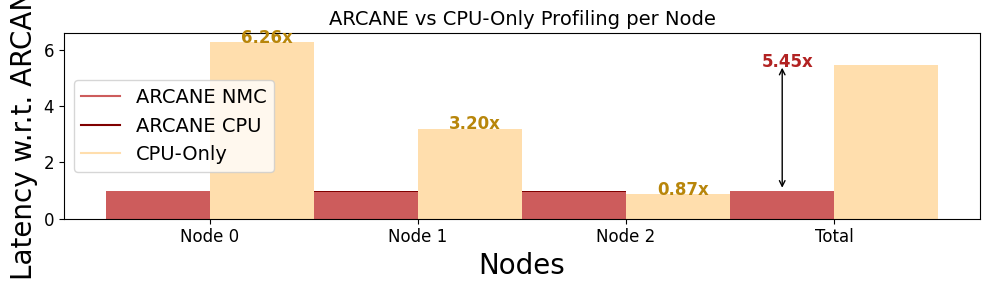

In [8]:
# Combine ARCANE and CPU values for ARCANE_PROFILING
bar_width = 0.5
arcane_values = [
    node["ARCANE"] for node in ARCANE_PROFILING
]
cpu_easy_values = [ node["CPU"] for node in ARCANE_PROFILING]
# Extract CPU-only values from CPU_ONLY_PROFILING
cpu_only_values = [node["CPU"] for node in CPU_ONLY_PROFILING]

# Normalize the values
nodes = range(len(ARCANE_PROFILING))
fig, ax = plt.subplots(figsize=(10, 3))
# Plot ARCANE bars
for n in nodes:
    total_arcane = arcane_values[n] + cpu_easy_values[n]
    arcane_bars = ax.bar(
        n - bar_width / 2,
        arcane_values[n]/total_arcane,
        bar_width,
        color="indianred",
    )

    cpu_arcane_bars = ax.bar(
        n - bar_width / 2,
        cpu_easy_values[n]/total_arcane,
        bar_width,
        bottom=arcane_values[n]/total_arcane,
        color="maroon",
    )

    # Plot CPU-only bars
    cpu_bars = ax.bar(
        n + bar_width / 2,
        cpu_only_values[n]/total_arcane,
        bar_width,
        color="navajowhite",
    )

    ax.text(
        n + bar_width / 2 - 0.1,
        (cpu_only_values[n]/total_arcane)+0.15,
        f'{cpu_only_values[n]/total_arcane:.2f}x',
        ha='left', va='center', color='darkgoldenrod',
        fontweight='bold',
        fontsize=12,
    )

total_arcane = sum([arcane_values[n] + cpu_easy_values[n] for n in nodes])
total_cpu_only = sum(cpu_only_values)

arcane_bars = ax.bar(
    len(nodes) + bar_width / 2,
    total_cpu_only/total_arcane,
    bar_width,
    color="navajowhite",
)
cpu_bars = ax.bar(
    len(nodes) - bar_width / 2,
    1,
    bar_width,
    color="indianred",
)
# Add an arrow and text to show the improvement
improvement = total_cpu_only / total_arcane
x_pos = len(nodes) - bar_width / 2
ax.annotate(
    '',
    xy=(x_pos, 1), 
    xytext=(x_pos, total_cpu_only/total_arcane),
    arrowprops=dict(arrowstyle='<->', color='black'),
    ha='center', va='center'
)
ax.text(
    x_pos - 0.1,
    (total_cpu_only/total_arcane)+0.1,
    f'{improvement:.2f}x',
    ha='left', va='center', color='firebrick',
    fontweight='bold',
    fontsize=12,
)
# Add labels and legend
ax.set_xlabel("Nodes")
ax.set_ylabel("Latency w.r.t. ARCANE")
ax.set_title("ARCANE vs CPU-Only Profiling per Node")
ax.set_xticks([n for n in nodes]+[len(nodes)])
ax.set_xticklabels([f"Node {n}" for n in nodes]+["Total"])
plt.legend(handles=[
    plt.Line2D([0], [0], color="indianred", label='ARCANE NMC'),
    plt.Line2D([0], [0], color="maroon", label='ARCANE CPU'),
    plt.Line2D([0], [0], color="navajowhite", label='CPU-Only'),
]
)
# Show the plot
plt.tight_layout()
plt.show()